In [8]:
import math
class ag: # AutoGrad
    def log(input):
        output = ag.Scalar(math.log(input.value), inputs=[input], op="log")

        def _backward():
            # YOUR CODE HERE
            return None

        output._backward = _backward
        return output

    def exp(input):

        output = ag.Scalar(math.exp(input.value), inputs=[input], op="exp")

        def _backward():
            input.grad += output.grad * output.value
            return None

        output._backward = _backward
        return output

    def relu(input):
        output = ag.Scalar(max(0, input.value), inputs=[input], op="relu")

        def _backward():
            if input.value > 0:
                input.grad += output.grad

        output._backward = _backward
        return output


    class Scalar: # Scalars with grads
        def __init__(self,  value, op="", _backward= lambda : None, inputs=[], label=""):

            self.value = float(value)
            self.grad = 0.0

            self._backward = _backward
            self.inputs = inputs

            self.op = op
            self.label = label


        def topological_sort(self):
            topo_order = []
            visited = set()

            def dfs(node):
                if node not in visited:
                    visited.add(node)
                    for input in node.inputs:
                        dfs(input)
                    topo_order.append(node)

            dfs(self)
            return topo_order

        def backward(self):
            self.grad = 1.0

            topo_order = self.topological_sort()

            for node in reversed(topo_order):
                node._backward()


        def __add__(self, other):
            if not isinstance(other, ag.Scalar):
                other = ag.Scalar(other, label=f"{other}\nconst")

            output = ag.Scalar(self.value + other.value,
                               inputs=[self, other], op="add")

            def _backward():
                # pass
                self.grad += output.grad
                other.grad += output.grad

            output._backward = _backward
            return output


        def __mul__(self, other):
            assert isinstance(other, ag.Scalar)
            output = ag.Scalar(self.value * other.value, inputs=[self, other], op="mul")

            def _backward():
                self.grad += other.value * output.grad
                other.grad += self.value * output.grad

                return None

            output._backward = _backward

            return output

        def __pow__(self, exponent): # exponent is just a python float
            output = ag.Scalar(self.value ** exponent, inputs=[self], op=f"pow({exponent})")

            def _backward():
                self.grad += (exponent * self.value**(exponent-1)) * output.grad
                return None

            output._backward = _backward
            return output

        def __neg__(self): # exponent is just a python float
            output = ag.Scalar(-self.value, inputs=[self], op=f"neg")

            def _backward():
                self.grad += (-1) * output.grad
                return None

            output._backward = _backward
            return output
        
        def __repr__(self) -> str:
            return str("val:" + str(self.value) + ", grad:" + str(self.grad))



# Exercise : Calculate the cross entropy using agScalar

In [9]:
# note 1: you need to modify 
# class ag: # AutoGrad
#    def log(input):
# note 2: we currently don't have division support. Unless...

z1 = ag.Scalar(1, 'z1')
z2 = ag.Scalar(2, 'z2')
z3 = ag.Scalar(3, 'z3')
# your code here

# output.backward()

(z1.grad, z2.grad, z3.grad)

(0.0, 0.0, 0.0)

## Check the above against the analytic formula

In [10]:
import numpy as np
z = np.array([1,2,3])

ce_der = np.exp(z)/ np.sum(np.exp(z)) - np.array([0,1,0])
ce_der

array([ 0.09003057, -0.75527153,  0.66524096])

# Exercise : a relu network

In [36]:
import numpy as np

class Model:
    def __init__(self, n_hidden,rng_seed = 42):
        np.random.seed(rng_seed)

        w1np = np.random.randn(n_hidden)
        b1np = np.random.randn(n_hidden)
        w2np = np.random.randn(n_hidden)
        b2np = np.random.randn(1)

        self.w1 = [ag.Scalar(val) for val in w1np]
        self.b1 = [ag.Scalar(val) for val in b1np]
        self.w2 = [ag.Scalar(val) for val in w2np]
        self.b2 = [ag.Scalar(val) for val in b2np]

        self.n_hidden = n_hidden

        self.parameters = self.w1 + self.b1 + self.w2 + self.b2

    def forward(self, x):
        # x is a 1-dimensional numpy array
        # "upgrade" x into ag.Scalars
        x_scalar = [ag.Scalar(val) for val in x]
        n_samples = len(x_scalar)

        # calculate the forward

        # create a list of lists to keep track of the hidden neurons
        h = [[ ag.relu(self.w1[j]*x_i + self.b1[j]) for j in range(self.n_hidden)] for x_i in x_scalar]
        
        # a list of length n_samples, where each entry is a relu(w1 x[i] +b) dot w2
        w2h = [ag.Scalar(0.0) for i in range(n_samples)]
        for i in range(n_samples):
            for j in range(self.n_hidden):
                w2h[i] += self.w2[j] * h[i][j]
                

        return [w2h[i] + self.b2[0] for i in range(n_samples)]



class Loss:
    def mse(self, predictions, targets):
        # mean squared error
        assert len(predictions) == len(targets)
        n_samples = len(predictions)
        loss = ag.Scalar(0.0)

        for i in range(n_samples):
            error = predictions[i] + (-ag.Scalar(targets[i]))
            #    yhat[i]-y[i]
            loss = loss + error**2
        loss = loss * ag.Scalar(1/n_samples)
        return loss


class Optimizer:
    def __init__(self, parameters, lr=0.01):
        self.parameters = parameters
        self.lr = lr

    def zero_grad(self):
        # need to reset all the grad fields to zero 
        for param in self.parameters:
            param.grad = 0.0
        pass

    def step(self):
        # a single gradient descent step with learning rate self.lr
        for param in self.parameters:
            param.value -= self.lr * param.grad
        pass




In [37]:
def to_numpy(ag_Scalar_list):
    return np.array([scalar.value for scalar in ag_Scalar_list])


# Generate some synthetic data

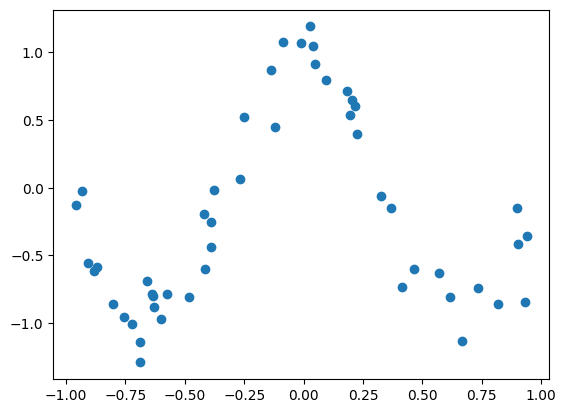

In [32]:
import numpy as np
import matplotlib.pyplot as plt

N = 50

np.random.seed(42)
xnp = 2.0*(np.random.rand(N)-0.5) # note that i'm using rand instead of randn

eps = (1/5)*np.random.randn(N)
ynp = np.cos((3/2)*np.pi*xnp) + eps

plt.scatter(xnp, ynp)

# Visualize the model at the beginning

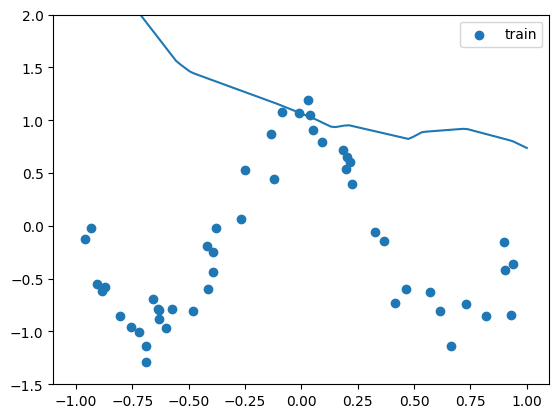

In [33]:
n_hidden = 20
loss_fn = Loss()
model = Model(n_hidden=n_hidden)
output = model.forward(xnp)
loss = loss_fn.mse(output, ynp)
loss.backward()

plt.scatter(xnp,ynp, label='train')
plt.ylim([-1.5,2.0])

x_grid = np.linspace(-1,1,100)

y_grid = model.forward(x_grid)

plt.plot(x_grid,to_numpy(y_grid))
plt.legend()

# Train!

In [34]:

n_hidden = 20
model = Model(n_hidden=n_hidden)
optimizer = Optimizer(model.parameters, lr=0.1)


for epoch in range(100):
    optimizer.zero_grad()
    output = model.forward(xnp)
    loss = loss_fn.mse(output, ynp)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Iteration {epoch}, Loss: {loss.value}")

Iteration 0, Loss: 3.6301518820544976
Iteration 10, Loss: 0.2582639019771399
Iteration 20, Loss: 0.18628074533544114
Iteration 30, Loss: 0.16072217110467135
Iteration 40, Loss: 0.1467600095145268
Iteration 50, Loss: 0.13821133135695676
Iteration 60, Loss: 0.13148817078641828
Iteration 70, Loss: 0.12566843762326202
Iteration 80, Loss: 0.12086485496274221
Iteration 90, Loss: 0.11662280564984422


# Visualize the model at the end of the training

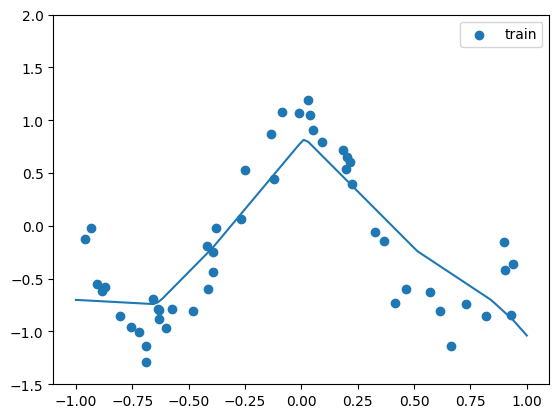

In [35]:
plt.scatter(xnp,ynp, label='train')
plt.ylim([-1.5,2.0])

x_grid = np.linspace(-1,1,100)

y_grid = model.forward(x_grid)

plt.plot(x_grid,to_numpy(y_grid))
plt.legend()